In [1]:
import os
import numpy as np
import pandas as pd
from obspy import read
from tensorflow import keras

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
splits_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms"
encoder_path = r"E:\Skripsi\DEC\2-DEC\tuning2_freq\encoder.h5"  # path hasil simpan dari Autoencoder.ipynb
batch_size = 64

encoder = keras.models.load_model(encoder_path, compile=False)
latent_dim = encoder.output_shape[1]
print(f"Encoder loaded. Latent dim = {latent_dim}")

Encoder loaded. Latent dim = 128


In [6]:
def extract_features_from_manifest(manifest_csv, encoder, output_csv, batch_size):
    df = pd.read_csv(manifest_csv)
    fname_col = "filename"
    feat_cols = [f"f{i+1}" for i in range(encoder.output_shape[1])]
    if os.path.exists(output_csv):
        os.remove(output_csv)
    first_write = True

    n = len(df)
    for start in range(0, n, batch_size):
        batch = df.iloc[start:start+batch_size]
        Xb, names, labels = [], [], []

        for _, row in batch.iterrows():
            # Load spectrogram npy
            data = np.load(row["path"]).astype(np.float32)  # shape (128,128)
            data = np.expand_dims(data, -1)                 # (128,128,1)
            Xb.append(data)
            names.append(row[fname_col])
            labels.append(row["label"])

        Xb = np.array(Xb, dtype=np.float32)  # (batch,128,128,1)

        # Get latent representation
        Z = encoder.predict(Xb, batch_size=len(Xb), verbose=0)

        # Store as dataframe
        out_rows = []
        for i in range(Z.shape[0]):
            r = {fname_col: names[i], "label": labels[i]}
            for j, val in enumerate(Z[i]):
                r[f"f{j+1}"] = float(val)
            out_rows.append(r)

        pd.DataFrame(out_rows).to_csv(output_csv, mode="a", index=False, header=first_write)
        first_write = False

        print(f"Processed {min(start+batch_size, n)}/{n}", end="\r")

    print(f"\n✅ Saved latent features to: {output_csv}")


In [8]:
extract_features_from_manifest(
    os.path.join(splits_root, "train.csv"),
    encoder,
    os.path.join(splits_root, "train_latent.csv"),
    batch_size=batch_size
)

extract_features_from_manifest(
    os.path.join(splits_root, "test.csv"),
    encoder,
    os.path.join(splits_root, "test_latent.csv"),
    batch_size=batch_size
)

Processed 3861/3861
✅ Saved latent features to: E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms\train_latent.csv
Processed 966/966
✅ Saved latent features to: E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms\test_latent.csv


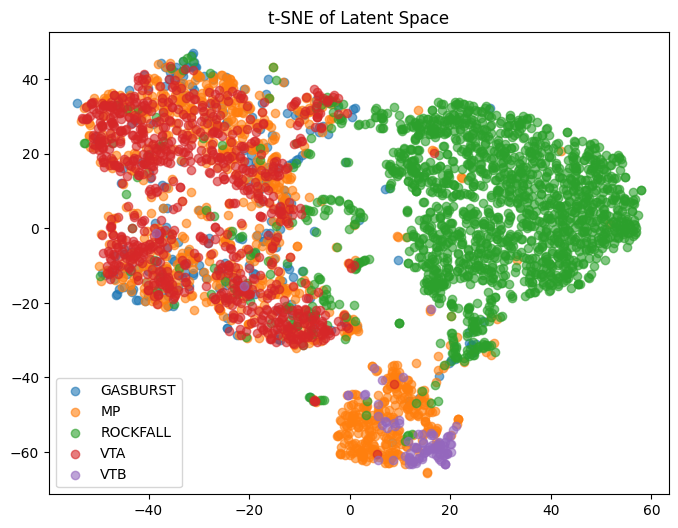

In [13]:
# Ambil latent features dari train_latent.csv
df = pd.read_csv(r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms\train_latent.csv")
X = df.drop(columns=["filename","label"]).values
y = df["label"].values

X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(8,6))
for label in np.unique(y):
    idx = (y == label)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of Latent Space")
plt.show()


e:\Skripsi\DEC\envTA\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


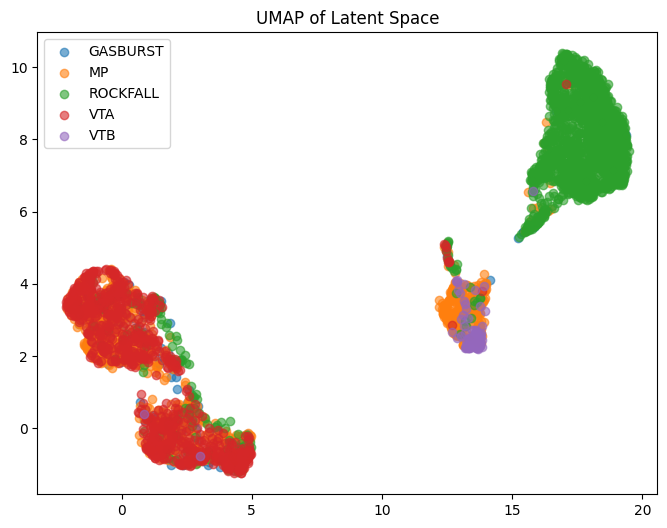

In [16]:

import umap.umap_ as umap  

# Load latent features
df = pd.read_csv(r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\split-spectograms\train_latent.csv")
X = df.drop(columns=["filename","label"]).values
y = df["label"].values

# UMAP projection
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric="euclidean")
X_2d = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(y):
    idx = (y == label)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=label, alpha=0.6)
plt.legend()
plt.title("UMAP of Latent Space")
plt.show()
